<a href="https://colab.research.google.com/github/ChengyangHuang/Divergence-Estimation/blob/main/codes/Nonparametric_Divergence_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Divergence Estimator

TODOes
- Implement more methods

In [305]:
import numpy as np
import math

from scipy.spatial import distance_matrix
from scipy.special import gamma

from sklearn.neighbors import KernelDensity
from sklearn.neighbors import NearestNeighbors

import cvxpy as cp 

from tqdm.notebook import  tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


class divergence_estimator():
    def __init__(self, rvs_1, rvs_2):
        assert rvs_1.shape[1] == rvs_2.shape[1]
        self.rvs_1 = rvs_1
        self.rvs_2 = rvs_2
        self.N = rvs_1.shape[0]
        self.M = rvs_2.shape[0]
        self.d = rvs_1.shape[1]
        

    def kl_intg(self):
        pass

    def renyi_alpha_integral(self):
        pass

    def renyi_alpha_divergence(self):
        pass


## k-NN Methods


In [306]:
class knn_estimator(divergence_estimator):
    def __init__(self, rvs_1, rvs_2, n_neighbors):
        super().__init__(rvs_1, rvs_2)
        self.k = n_neighbors

    def kl_intg(self):
        pass

    def renyi_alpha_integral(self, alpha=0.5, fast=True):
        """
            Nonparametric Divergence Estimation with Applications to Machine Learning on Distributions
            https://arxiv.org/abs/1202.3758
        """

        B = gamma(self.k)**2 / (gamma(self.k - alpha + 1) * gamma(self.k + alpha - 1))
        if fast:
            self.knn_1 = NearestNeighbors(n_neighbors=self.k, algorithm='auto').fit(self.rvs_1)
            self.knn_2 = NearestNeighbors(n_neighbors=self.k, algorithm='auto').fit(self.rvs_2)
            rho = self.knn_1.kneighbors(self.rvs_1)[0][:, -1]
            nu = self.knn_2.kneighbors(self.rvs_1)[0][:, -1]
        else:
            dist_mat_11 = distance_matrix(self.rvs_1, self.rvs_1)
            dist_mat_12 = distance_matrix(self.rvs_1, self.rvs_2)
            dist_mat_11.sort(axis=1)
            dist_mat_12.sort(axis=1)
            rho = dist_mat_11[:, self.k]
            nu = dist_mat_12[:, self.k-1]

        renyi_alpha = B / self.N * np.sum(np.divide((self.N-1)*rho**self.d, self.M*nu**self.d)**(1-alpha))
        return renyi_alpha

## Ensemble Methods

In [307]:
class EnDive(divergence_estimator):
    def __init__(self, rvs_1, rvs_2, kmin, kmax, L):
        super().__init__(rvs_1, rvs_2)
        self.kmin = kmin
        self.kmax = kmax
        self.L = L
    
    def construct_L_set(self):
        pass

    def find_optimal_weight(self):
        pass

### Ensemble KNN



In [308]:
class EnDive_KNN(EnDive):
    def __init__(self, rvs_1, rvs_2, kmin=1, kmax=40, L=60, alpha_frac=0.5):
        super().__init__(rvs_1, rvs_2, kmin, kmax, L)
        self.M_2 = int(alpha_frac*self.N)
        idx1 = np.random.choice(self.N, self.M_2, replace=False)
        idx2 = np.delete(np.arange(self.N), idx1)
        self.rvs_11 = self.rvs_1[idx1, :]
        self.rvs_12 = self.rvs_1[idx2, :]

        self.construct_L_set(self.M_2)
        self.find_optimal_weight()

    def construct_L_set(self, M_2):
        M_2_sqrt = math.sqrt(M_2)
        self.L_set = np.linspace(self.kmin/M_2_sqrt, self.kmax/M_2_sqrt, self.L)
        self.k_set = np.int_(np.ceil(self.L_set * M_2_sqrt))

    def find_optimal_weight(self):
        psi = lambda i: self.L_set[np.newaxis, :] ** (i / self.d)
        J = np.arange(1, self.d)

        w = cp.Variable(self.L)
        objective = cp.Minimize(cp.norm(w, 2))
        constraints = [np.ones((1, self.L)) @ w == 1]
        for i in J:
            constraints.append(psi(i) @ w <= 0.1)
        problem = cp.Problem(objective, constraints)
        problem.solve()
        self.weight = w.value
        # print(self.weight)

    def renyi_alpha_integral(self, alpha):
        renyi_knn = []
        for l, k in zip(self.L_set, self.k_set):
            self.knn_1 = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(self.rvs_11)
            self.knn_2 = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(self.rvs_2)
            rho = self.knn_1.kneighbors(self.rvs_12)[0][:, -1]
            nu = self.knn_2.kneighbors(self.rvs_12)[0][:, -1]
            f1_pdf = k / self.M_2 / np.pi**(self.d/2) * gamma(self.d/2+1) / rho**self.d
            f2_pdf = k / self.M / np.pi**(self.d/2) * gamma(self.d/2+1) / nu**self.d
            renyi_knn.append(np.dot((f1_pdf ** alpha), (f2_pdf ** (1-alpha))) / (self.N - self.M_2))
            # knn_est = knn_estimator(self.rvs_1, self.rvs_2, n_neighbors=k)
            # renyi_knn.append(knn_est.renyi_alpha_integral(alpha, fast=True))
        renyi_knn = np.array(renyi_knn)
        # print(renyi_knn)
        renyi_EnDive = np.dot(self.weight, renyi_knn)
        return renyi_EnDive

### Ensemble KDE

In [309]:
class EnDive_KDE(EnDive):
    """
        Ensemble estimation of information divergence
        https://www.mdpi.com/1099-4300/20/8/560
    """
    def __init__(self, rvs_1, rvs_2, kmin=1, kmax=60, L=60, eta=1, delta=1):
        super().__init__(rvs_1, rvs_2, kmin, kmax, L)
        self.eta = eta
        self.delta = delta
        
        self.construct_L_set()
        self.find_optimal_weight()

    def construct_L_set(self):
        rvs_all = np.vstack((self.rvs_1, self.rvs_2))
        neigh_dist = NearestNeighbors(n_neighbors=self.kmax).fit(rvs_all).kneighbors()[0]
        lmin = neigh_dist[:, self.kmin].max() / (self.N ** (-1 / (self.d + self.delta)))
        lmax = neigh_dist[:, -1].max() / (self.N ** (-1 / (self.d + self.delta)))
        self.L_set = np.linspace(lmin, lmax, self.L)

    def find_optimal_weight(self):
        lam = math.ceil(self.d / self.delta) + 1
        s = math.ceil((self.d + self.delta) / 2) 
        eps = cp.Variable()
        w = cp.Variable(self.L)
        objective = cp.Minimize(eps)
        constraints = [np.ones((1, self.L)) @ w == 1,
                       cp.norm(w, 2) ** 2 <= self.eta * eps]

        for q in range(math.ceil(lam / 2) + 1):
            for j in range(s+1):
                if (j + q) > 0 and (j + q) < ((self.d + 1) / 2):
                    constraints.append(self.N ** (-(j+q)/(self.d+1) + 1/2) * (w @ (self.L_set**(j - self.d * q)) ) <= eps)

        problem = cp.Problem(objective, constraints)
        problem.solve() 
        self.weight = w.value

    def renyi_alpha_integral(self, alpha=0.5, kernel='tophat'):
        renyi_KDE = []
        for l in self.L_set:
            kde_1 = KernelDensity(kernel=kernel, bandwidth=(l*self.N**(-1/(self.d+self.delta)))).fit(self.rvs_1)
            kde_2 = KernelDensity(kernel=kernel, bandwidth=(l*self.N**(-1/(self.d+self.delta)))).fit(self.rvs_2)
            f1_pdf = np.exp(kde_1.score_samples(self.rvs_1))
            f2_pdf = np.exp(kde_2.score_samples(self.rvs_1))
            renyi_KDE.append(np.dot((f1_pdf ** alpha), (f2_pdf ** (1-alpha))) / self.N)

        renyi_KDE = np.array(renyi_KDE)
        renyi_EnDive = np.dot(self.weight, renyi_KDE)
        return renyi_EnDive, renyi_KDE

# Experiments

TODOes:
- Save results (using pandas or csv)
- More sophiscated Distribution
- KL Divergence and others

## Convergence Rates Validation: Rényi-α Divergence

### Truncated Gaussian

In [310]:
from scipy.stats import truncnorm
import scipy.integrate as integrate    


def renyi_alpha_div_integral(alpha, p, q, a, b, N=None):
    if N == None:
        return integrate.quad(lambda x: (p(x) ** alpha) * (q(x) ** (1 - alpha)), a, b)
    else:
        x = np.linspace(a, b, N)
        return np.dot(p(x) ** alpha, q(x) ** (1 - alpha)) / N


def kl_div_integral(p, q, a, b, N=None):
    if N == None:
        return integrate.quad(lambda x: p(x) * math.log(p(x)/q(x)), a, b)
    else:
       x = np.linspace(a, b, N)
       return np.dot(p(x), np.log(p(x)/q(x))) / N


def truncated_Gaussian_experiment(d=5, N=2000, 
                                  mu_1=0.7, sigma_1=np.sqrt(0.4),
                                  mu_2=0.3, sigma_2=np.sqrt(0.4),
                                  a=0, b=1, plot=False):
    
    a_1, b_1 = (a - mu_1) / sigma_1, (b - mu_1) / sigma_1
    a_2, b_2 = (a - mu_2) / sigma_2, (b - mu_2) / sigma_2

    f_1 = truncnorm(a_1, b_1, mu_1, sigma_1)
    f_2 = truncnorm(a_2, b_2, mu_2, sigma_2)
    rvs_1 = f_1.rvs(size=(N, d))
    rvs_2 = f_2.rvs(size=(N, d))

    # Plot pdf
    if plot:
        x = np.linspace(a, b, 1000)
        pdf_1 = f_1.pdf(x)
        pdf_2 = f_2.pdf(x)
        fig, ax = plt.subplots(1, 1)
        ax.plot(x, f_1.pdf(x), label='f1')
        ax.plot(x, f_2.pdf(x), label='f2')
        ax.set_ylabel("pdf")
        ax.legend()

    # Renyi-alpha
    renyi_alpha_dict = {}
    alpha = 0.5 
    renyi_alpha_dict["GT_integral"] = renyi_alpha_div_integral(alpha, f_1.pdf, f_2. pdf, a, b)[0]**d
    renyi_alpha_dict["GT_numerial_est"] = renyi_alpha_div_integral(alpha, f_1.pdf, f_2. pdf, a, b, N)**d
    
    knn_est = knn_estimator(rvs_1, rvs_2, n_neighbors=20)
    renyi_alpha_dict["KNN_fast"] = knn_est.renyi_alpha_integral(alpha, fast=True)
    renyi_alpha_dict["KNN_brute"] = knn_est.renyi_alpha_integral(alpha, fast=False)
    
    endiveKDE_est = EnDive_KDE(rvs_1, rvs_2, kmax=60)
    renyi_endiveKDE, renyi_KDE = endiveKDE_est.renyi_alpha_integral(alpha)
    renyi_alpha_dict["EnDive_KDE"] = renyi_endiveKDE
    renyi_alpha_dict["KDE_best"] = renyi_KDE[((renyi_KDE - renyi_alpha_dict["GT_integral"])**2).argmin()]

    endiveKNN_est = EnDive_KNN(rvs_1, rvs_2, kmin=10, kmax=60, L=50)
    renyi_alpha_dict["EnDive_KNN"] = endiveKNN_est.renyi_alpha_integral(alpha)

    # KL
    kl_gt1 = kl_div_integral(f_1.pdf, f_2. pdf, a, b)[0]
    kl_gt2 = kl_div_integral(f_1.pdf, f_2. pdf, a, b, 1000)

    return renyi_alpha_dict


truncated_Gaussian_experiment()

{'EnDive_KDE': 0.8908949737528011,
 'EnDive_KNN': 1.064500437638616,
 'GT_integral': 0.9533316996544592,
 'GT_numerial_est': 0.9528751587084865,
 'KDE_best': 0.6715666350567316,
 'KNN_brute': 0.966575778499174,
 'KNN_fast': 0.9397638156369582}

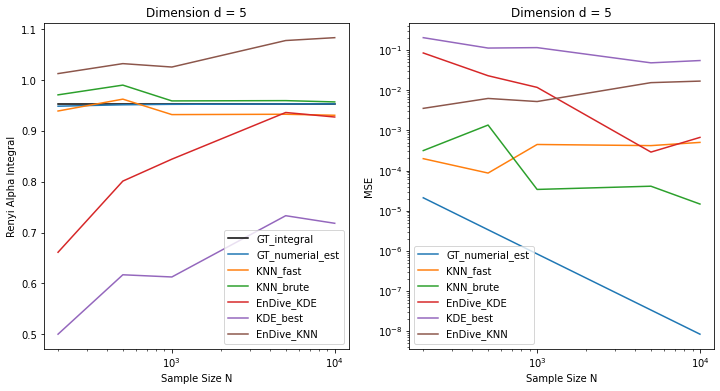

In [311]:
def convergence_validation():
    d_list = [5]
    N_list = [200, 500, 1000, 5000, 10000]

    for d in d_list:
        result_dict = {}
        for N in tqdm(N_list):
            renyi_alpha_dict = truncated_Gaussian_experiment(d, N)
            for key, value in renyi_alpha_dict.items():
                if key in result_dict.keys():
                    result_dict[key].append(renyi_alpha_dict[key])
                else:
                    result_dict[key] = [renyi_alpha_dict[key]]

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        for key, value in result_dict.items():
            if key != 'GT_integral':
                gt = np.array(result_dict['GT_integral'])
                value = np.array(value)
                ax[0].semilogx(N_list, value, label=key)
                ax[1].loglog(N_list, (gt - value)**2, label=key)
            else:
                ax[0].semilogx(N_list, value, label=key, color="black")
        ax[0].legend()
        ax[0].set_xlabel("Sample Size N")
        ax[0].set_ylabel("Renyi Alpha Integral")
        ax[0].set_title(f"Dimension d = {d}")

        ax[1].legend()
        ax[1].set_xlabel("Sample Size N")
        ax[1].set_ylabel("MSE")
        ax[1].set_title(f"Dimension d = {d}")
        plt.show()


convergence_validation()    

## Performance on Various Distribuion

### Truncated Gaussian: Various Mean and Variance 

In [ ]:
def vary_distribution_params():
    n_grid = 10
    mean_span = np.linspace(0, 1, n_grid)
    std_span = np.linspace(0.3, 0.7, n_grid)

    result_dict = {}

    for i in tqdm(range(n_grid)):
        for j in range(n_grid):
            mu_1 = mean_span[i]
            mu_2 = mean_span[j]

            sigma_1 = std_span[i]
            sigma_2 = std_span[j]

            renyi_alpha_dict = truncated_Gaussian_experiment(5, 2000, mu_1, sigma_1, mu_2, sigma_2)
            
            for key, value in renyi_alpha_dict.items():
                if key not in result_dict.keys():
                    result_dict[key] = [value]
                else:
                    result_dict[key].append(value)

    fig, ax = plt.subplots(1)
    for key, value in result_dict.items(): 
        ax.plot(value, label=key)
    ax.legend()
    ax.set_ylabel("Renyi-alpha Integral")
    ax.set_xlabel("Experiment ID.")

vary_distribution_params()